In [1]:
import pathlib

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import skimage
import skimage.io as io
import tifffile
from cellpose import core, models, utils
from rich.pretty import pprint

In [2]:
image_path = pathlib.Path("../processed_data/raw_z_input/nuclei_masks.tiff").resolve(
    strict=True
)
image = tifffile.imread(image_path)

cordinates = {
    "label": [],
    "slice": [],
    "centroid-0": [],
    "centroid-1": [],
}

for slice in range(image.shape[0]):
    props = skimage.measure.regionprops_table(
        image[slice, :, :], properties=["label", "centroid"]
    )

    label, centroid1, centroid2 = (
        props["label"],
        props["centroid-0"],
        props["centroid-1"],
    )
    if len(label) > 1:
        for i in range(len(label)):
            cordinates["label"].append(label[i])
            cordinates["slice"].append(slice)
            cordinates["centroid-0"].append(centroid1[i])
            cordinates["centroid-1"].append(centroid2[i])

coordinates_df = pd.DataFrame(cordinates)
coordinates_df["unique_id"] = coordinates_df.index
coordinates_df

,label,slice,centroid-0,centroid-1,unique_id
0,1,2,426.409489,1164.733196,0
1,2,2,665.656629,719.267363,1
2,1,3,426.389168,1164.546980,2
3,3,3,593.917286,1153.432633,3
4,4,3,692.398795,729.750196,4
...,...,...,...,...,...
164,38,30,780.116313,605.779199,164
165,38,32,778.565337,628.953232,165
166,39,32,781.924456,588.217093,166
167,38,33,779.525957,626.279149,167


## An attempt at an elegant solution to the 2D -> 3D object relation problem.
I will use graph theory to solve this problem. 
The idea is to create a graph where each node represents a 2D object and each edge represents a potential relation between two objects across z or an absolute relation between two objects in the same z.
These edges will be weighted based on their z distance.
The problem then becomes a shortest path problem where we need to find the shortest path between the start and end nodes.
An issue that will arise is figuring out how many nodes might exist in a given path. This will vary and will be a challenge to solve.
Some nodes will not start until a certain z level and some nodes will end at a certain z level.

### To do this we must make the following assumptions:
1. Nodes in the same z level are connected to each other, but will not be used in the shortest path calculation - these are separate objects.
2. The variablility in the distance between the X-Y coordinates across z-slices for the same 3D object is minimal.
    - This will be a learned or assumed value - probably initialized as apriori knowledge.
3. The distance between the X-Y coordinates across z-slices for different 3D objects is significant.
4. Given the assumption of 1 and 2, we do not need to calculate the shortes path between all nodes, only the nodes that are within a certain distance of each other in the X-Y plane across z-slices.
5. The total number of objects in a 2D slice cannot be greater than the total number of objects in the 3D object.
6. The largest number of objects across all 2D slices will not necessarily be the same as the number of objects in the 3D object.
7. The node path has to be continuous and cannot skip nodes.

In [3]:
# # create a simulated data set as a minimal reproducible example
# # this data set will have 2 cells across 3 slices with different centroids
# coordinates_df = pd.DataFrame({
#     "unique_id": [0, 1, 2, 3, 4, 5, 6, 7, 8],
#     "slice": [0, 1, 2, 0, 1, 2, 0, 1, 2],
#     "centroid-0": [10, 11, 15, 20, 22, 25, 31, 32, 35],
#     "centroid-1": [10, 11, 15, 20, 22, 25, 31, 32, 35],
# })
# coordinates_df

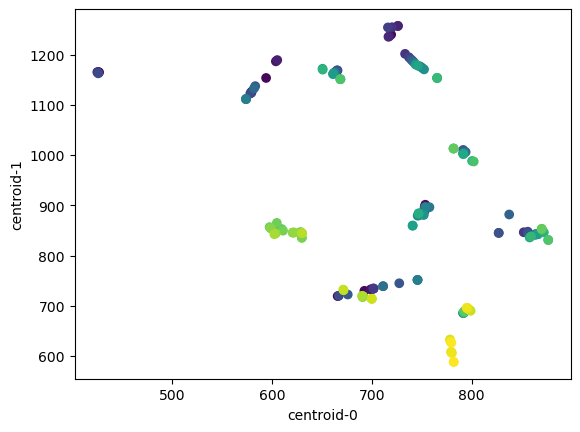

In [4]:
# plot the data
fig, ax = plt.subplots()
plt.scatter(
    coordinates_df["centroid-0"],
    coordinates_df["centroid-1"],
    c=coordinates_df["unique_id"],
)
plt.xlabel("centroid-0")
plt.ylabel("centroid-1")
# plt.ylim(0, 100)
plt.show()

In [5]:
# following assumption number 2 and 3
# we set the max radius of the cell to be 5 pixels
x_y_vector_radius_max_constaint = 10

# construct a graph of nodes and edges from the df
# where the nodes are the centroids of the cells
# and the edges are the distance between the centroids

# create a graph
G = nx.Graph()

# add nodes
for index, row in coordinates_df.iterrows():
    G.add_node(row["unique_id"], pos=(row["unique_id"], row["slice"]))

# connect the nodes across slices
for slice in coordinates_df["slice"].unique():
    nodes = coordinates_df[coordinates_df["slice"] == slice]
    nodes_next_slice = coordinates_df[coordinates_df["slice"] == slice + 1]
    # get the edge between all nodes in the same slice
    for index, row in nodes.iterrows():
        for index2, row2 in nodes_next_slice.iterrows():
            # check if the edge already exists
            if G.has_edge(row["unique_id"], row2["unique_id"]):
                continue
            elif G.has_edge(row2["unique_id"], row["unique_id"]):
                continue
            else:
                distance = np.sqrt(
                    (row["centroid-0"] - row2["centroid-0"]) ** 2
                    + (row["centroid-1"] - row2["centroid-1"]) ** 2
                )
                if distance < x_y_vector_radius_max_constaint:
                    G.add_edge(row["unique_id"], row2["unique_id"], weight=distance)

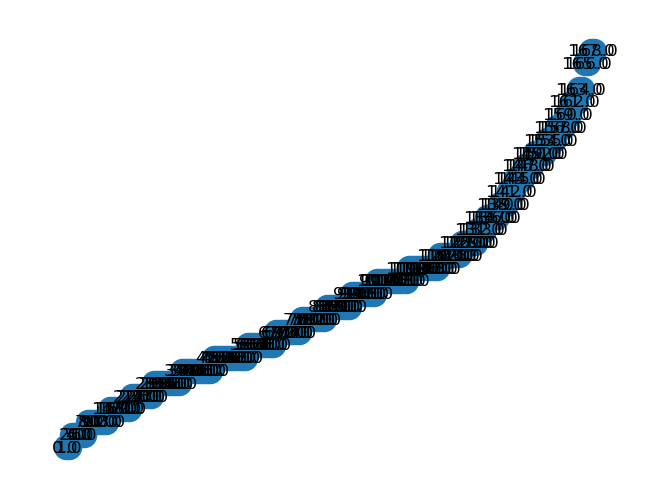

In [6]:
# Visualization of the graph for 3D data
# draw the graph
pos = nx.get_node_attributes(G, "pos")

nx.draw(G, pos, with_labels=True, connectionstyle="arc3,rad=0.2", arrows=True)
# make edges curved
edge_pos = nx.spring_layout(G)
plt.show()

In [7]:
import networkx as nx
import pandas as pd

# Assuming G is your graph and df is your original DataFrame

# Create a list to store the results
results = []

# Loop through the nodes and calculate longest paths with the shortest distances in a unidirectional way
for node1 in G.nodes:
    for node2 in G.nodes:
        if node1 != node2:
            # get the slices of the nodes
            slice1 = coordinates_df[coordinates_df["unique_id"] == node1][
                "slice"
            ].values[0]
            slice2 = coordinates_df[coordinates_df["unique_id"] == node2][
                "slice"
            ].values[0]
            if slice1 > slice2:
                continue
            try:
                path = nx.shortest_path(G, node1, node2)
                distance = nx.shortest_path_length(G, node1, node2, weight="weight")
                results.append([node1, node2, path, distance])
            except nx.NetworkXNoPath:
                results.append([node1, node2, None, None])

# Convert the results to a DataFrame
results_df = pd.DataFrame(results, columns=["node1", "node2", "path", "distance"])
results_df.head()

,node1,node2,path,distance
0,0.0,1.0,None,NaN
1,0.0,2.0,"[0.0, 2.0]",0.187321
2,0.0,3.0,None,NaN
3,0.0,4.0,None,NaN
4,0.0,5.0,None,NaN


In [8]:
# drop rows with no path
results_df = results_df.dropna()
print(results_df.shape)
results_df.head()

(422, 4)


,node1,node2,path,distance
1,0.0,2.0,"[0.0, 2.0]",0.187321
6,0.0,7.0,"[0.0, 2.0, 7.0]",0.992769
13,0.0,14.0,"[0.0, 2.0, 7.0, 14.0]",1.514097
20,0.0,21.0,"[0.0, 2.0, 7.0, 14.0, 21.0]",2.178997
27,0.0,28.0,"[0.0, 2.0, 7.0, 14.0, 21.0, 28.0]",3.419504


In [9]:
# drop a row if the path is contained in another path
# this is because we are only interested in the longest path with the shortest distance
# and not the subpaths
# ex. remove path pf [0, 1] if there is a path of [0, 1, 2]
rows_to_drop = []
# iterate over each row
for index, row in results_df.iterrows():
    # iterate over each row
    for index2, row2 in results_df.iterrows():
        # check if the path is a subset of another path
        if len(row["path"]) < len(row2["path"]):
            if set(row["path"]).issubset(row2["path"]):
                rows_to_drop.append(index)
        elif len(row["path"]) > len(row2["path"]):
            if set(row2["path"]).issubset(row["path"]):
                rows_to_drop.append(index2)
        else:
            continue
results_df.drop(index=rows_to_drop, inplace=True)
results_df

,node1,node2,path,distance
36,0.0,37.0,"[0.0, 2.0, 7.0, 14.0, 21.0, 28.0, 37.0]",4.859017
694,4.0,29.0,"[4.0, 9.0, 16.0, 22.0, 29.0]",10.370543
850,5.0,19.0,"[5.0, 12.0, 19.0]",5.191439
1078,6.0,81.0,"[6.0, 13.0, 20.0, 25.0, 32.0, 40.0, 49.0, 59.0...",24.470212
1087,6.0,90.0,"[6.0, 13.0, 20.0, 25.0, 32.0, 40.0, 49.0, 59.0...",28.872530
1101,6.0,104.0,"[6.0, 13.0, 20.0, 25.0, 32.0, 40.0, 49.0, 59.0...",28.872530
1334,8.0,15.0,"[8.0, 15.0]",2.863760
1672,10.0,31.0,"[10.0, 17.0, 24.0, 31.0]",10.557767
1841,11.0,39.0,"[11.0, 18.0, 23.0, 30.0, 39.0]",4.074235
4167,26.0,83.0,"[26.0, 33.0, 41.0, 50.0, 60.0, 68.0, 76.0, 83.0]",36.455816


In [10]:
# add an object number to each row
results_df.reset_index(drop=True, inplace=True)
results_df["object_number"] = results_df.index
results_df.drop(columns=["node1", "node2"], inplace=True)
# un group the path column
results_df = results_df.explode("path")
results_df.rename(columns={"path": "node"}, inplace=True)

In [11]:
# # get the x and y coordinates of each node from the original df
results_df["coorinate-0"] = results_df["node"].apply(
    lambda x: coordinates_df[coordinates_df["unique_id"] == x]["centroid-0"].values[0]
)
results_df["coorinate-1"] = results_df["node"].apply(
    lambda x: coordinates_df[coordinates_df["unique_id"] == x]["centroid-1"].values[0]
)
results_df["slice"] = results_df["node"].apply(
    lambda x: coordinates_df[coordinates_df["unique_id"] == x]["slice"].values[0]
)
results_df["label"] = results_df["node"].apply(
    lambda x: coordinates_df[coordinates_df["unique_id"] == x]["label"].values[0]
)
print(results_df.shape)
results_df

(200, 7)


,node,distance,object_number,coorinate-0,coorinate-1,slice,label
0,0.0,4.859017,0,426.409489,1164.733196,2,1
0,2.0,4.859017,0,426.389168,1164.546980,3,1
0,7.0,4.859017,0,425.643308,1164.851018,4,1
0,14.0,4.859017,0,425.200962,1164.575130,5,1
0,21.0,4.859017,0,424.801841,1165.106912,6,1
...,...,...,...,...,...,...,...
46,164.0,2.655743,46,780.116313,605.779199,30,38
47,165.0,2.841393,47,778.565337,628.953232,32,38
47,167.0,2.841393,47,779.525957,626.279149,33,38
48,166.0,0.000000,48,781.924456,588.217093,32,39


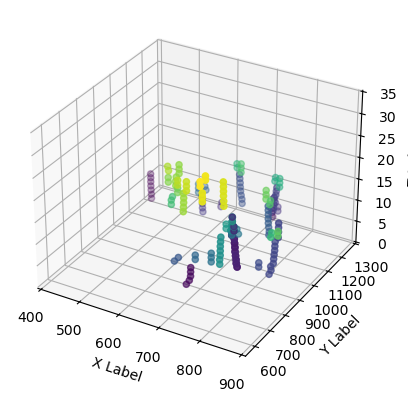

In [12]:
# plot the data in 3D with tracks
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    results_df["coorinate-0"],
    results_df["coorinate-1"],
    results_df["slice"],
    c=results_df["object_number"],
)
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")
plt.show()

In [13]:
# go back through the image and color each mask with the object number based on x and y coordinates for each slice
# create a new image with the same shape as the original image
new_image = np.zeros_like(image)
# iterate over each slice
for slice in range(image.shape[0]):
    # relate the object number to each mask
    for index, row in results_df[results_df["slice"] == slice].iterrows():
        # replace the mask label with the object number
        new_image[slice][image[slice] == row["label"]] = row["object_number"]

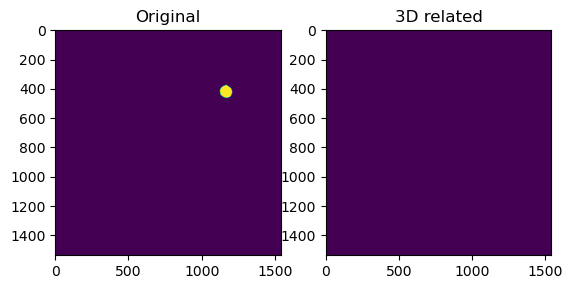

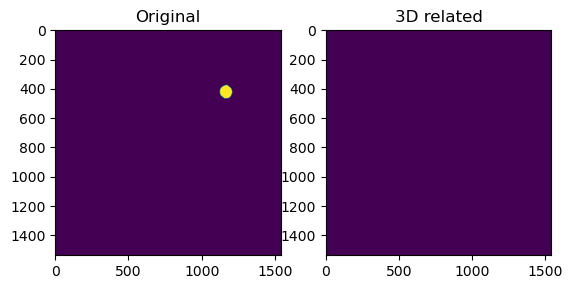

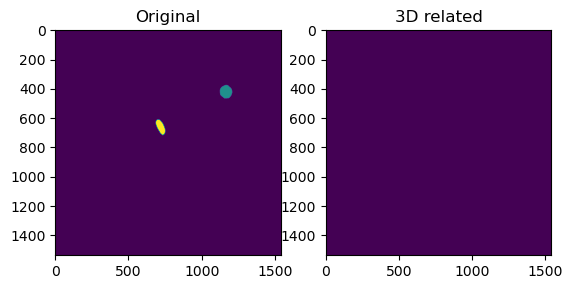

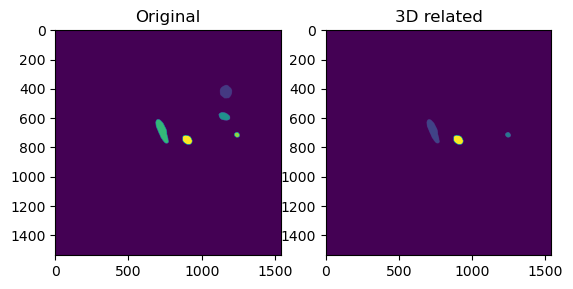

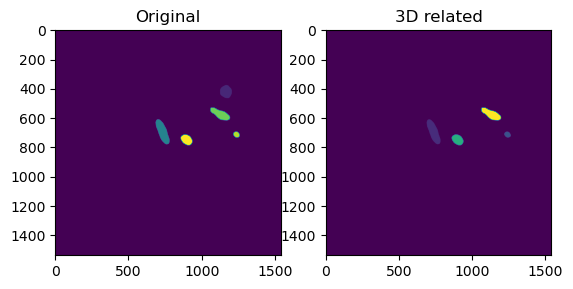

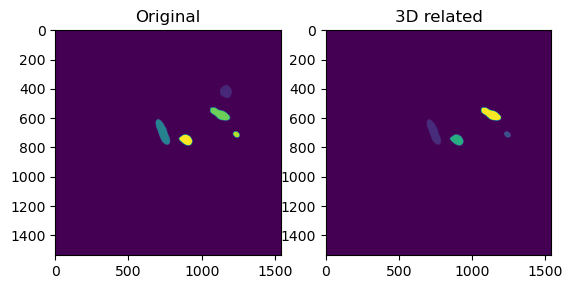

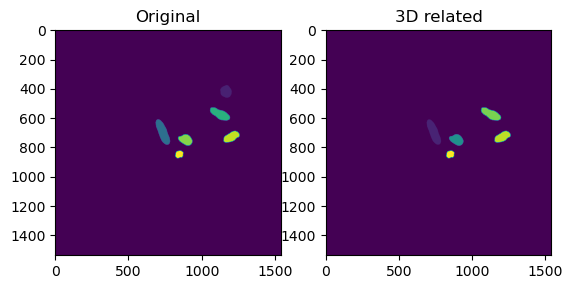

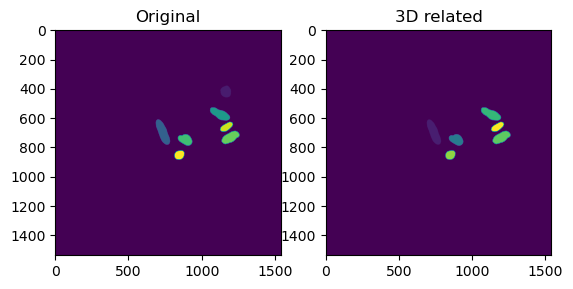

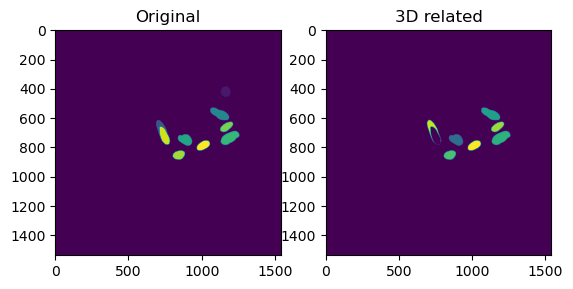

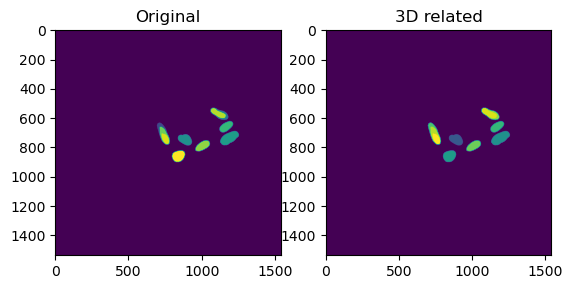

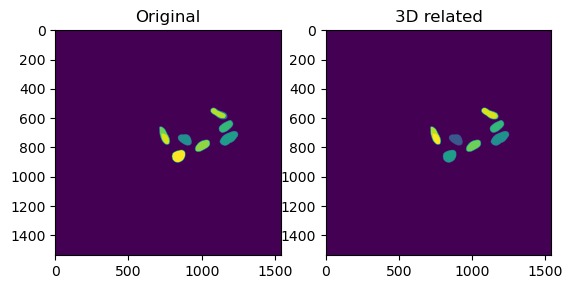

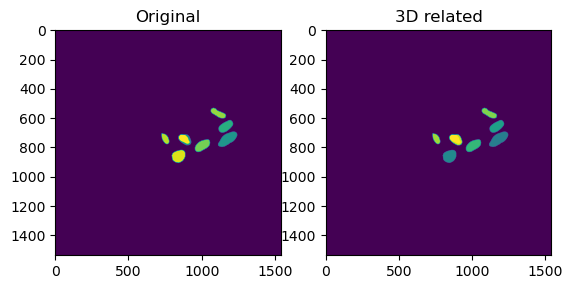

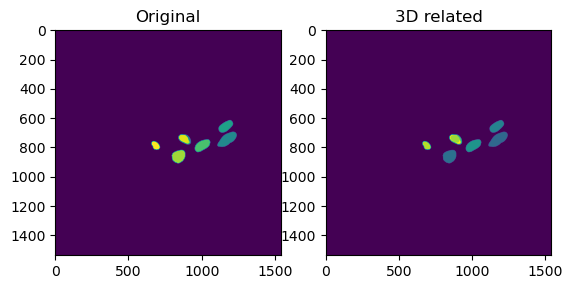

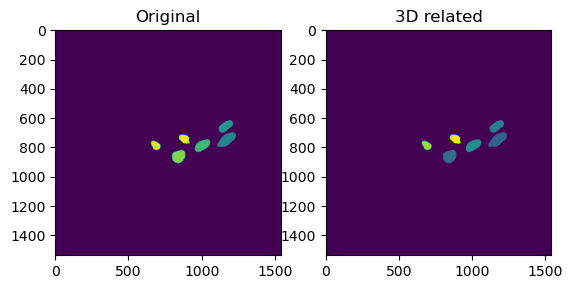

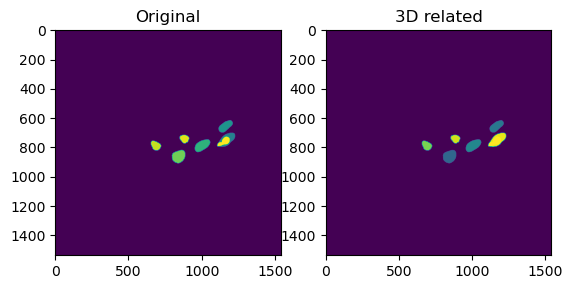

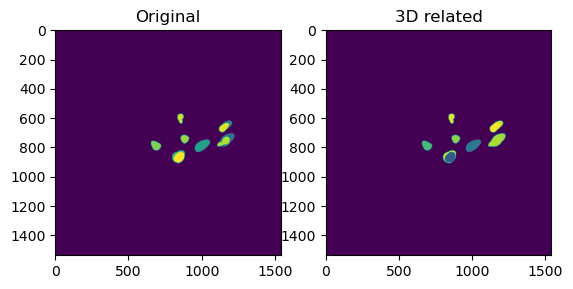

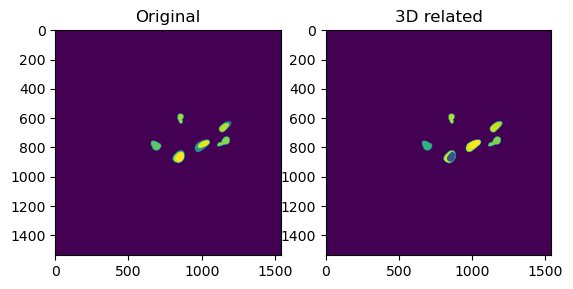

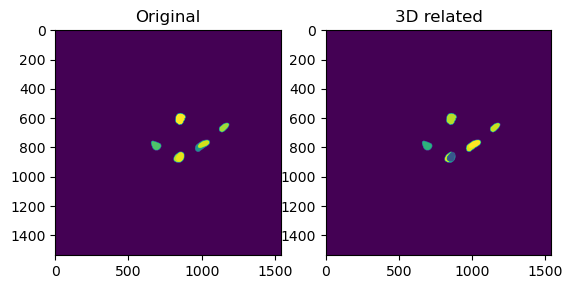

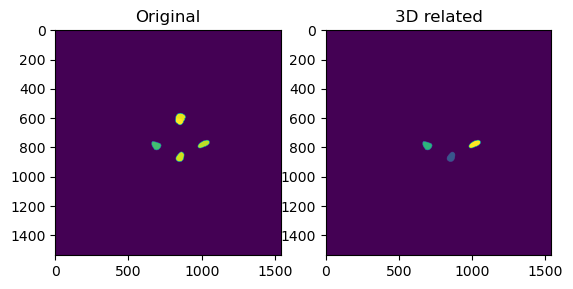

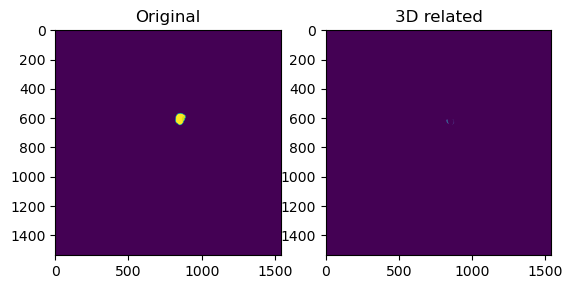

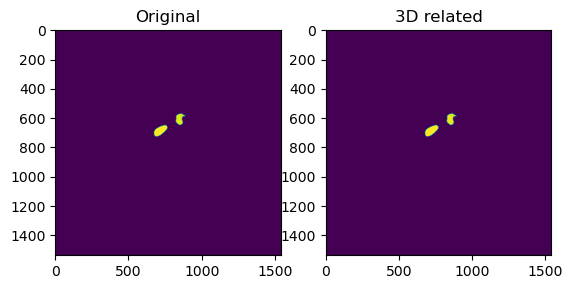

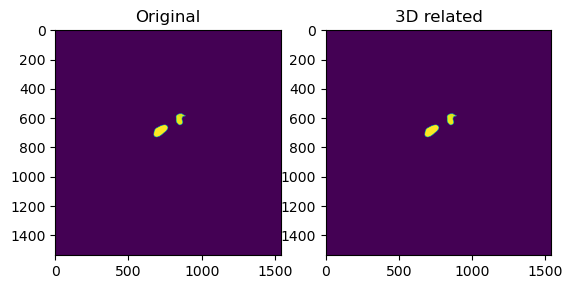

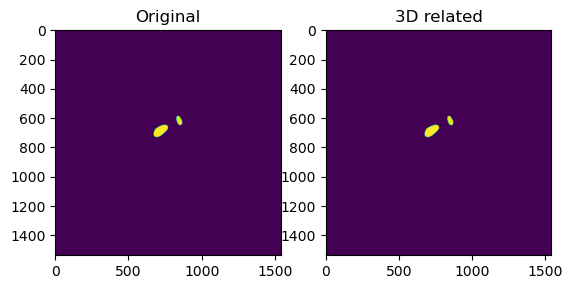

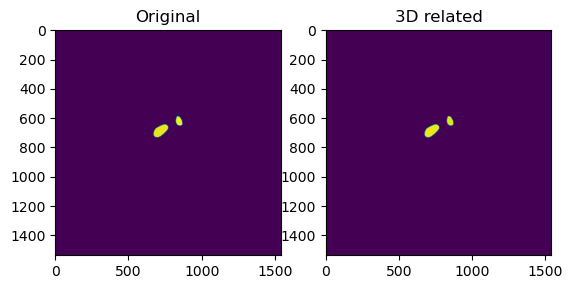

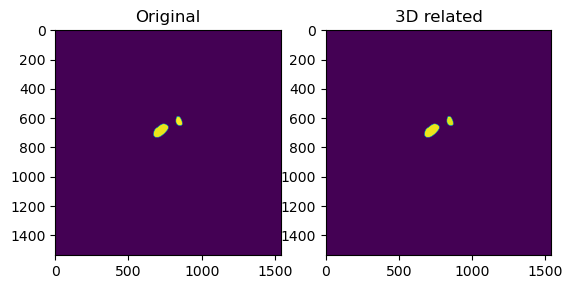

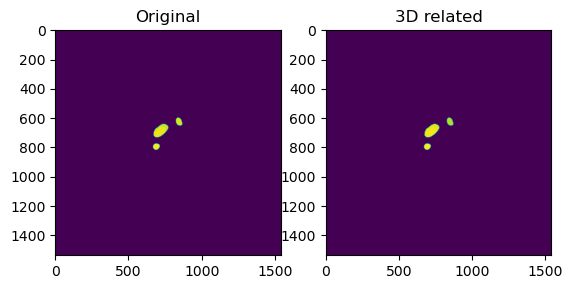

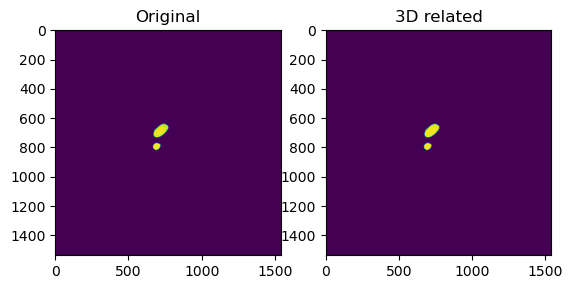

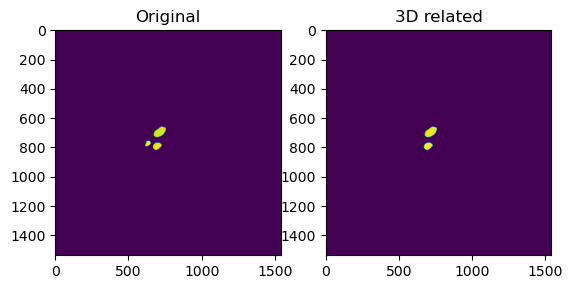

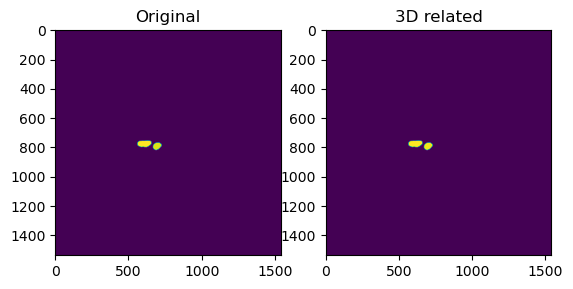

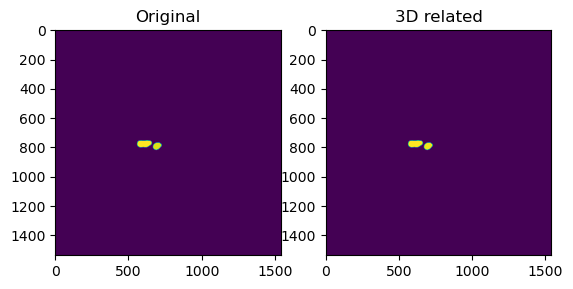

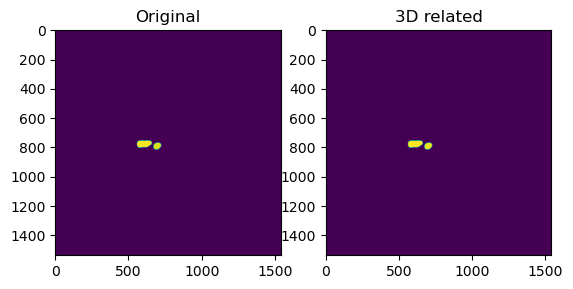

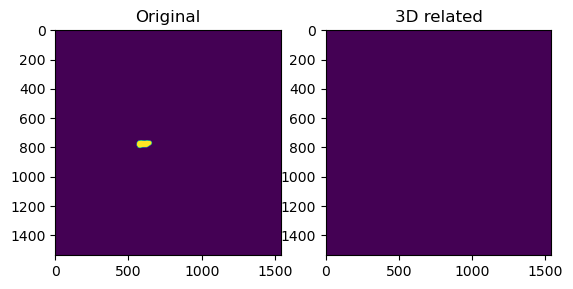

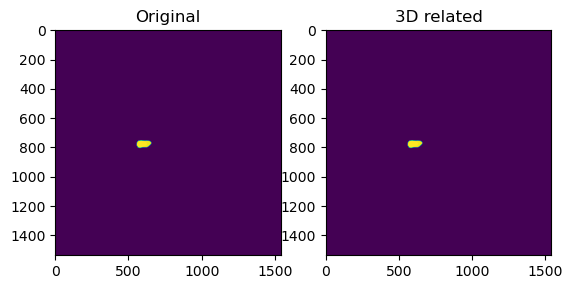

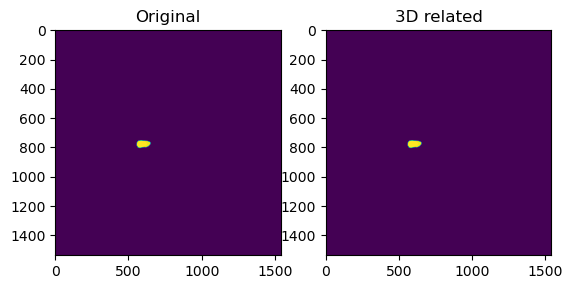

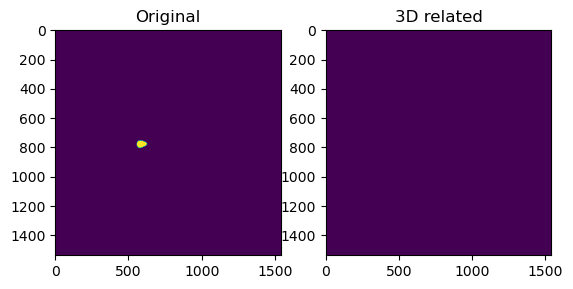

In [14]:
# plot the new image masks
for slice in range(new_image.shape[0]):
    plt.subplot(1, 2, 1)
    plt.imshow(image[slice])
    plt.title("Original")
    plt.subplot(1, 2, 2)
    plt.imshow(new_image[slice])
    plt.title("3D related")
    plt.show()